In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
ssdata = np.array([1114, 215, 662, 728, 594, 970, 882, 613, 509, 318, 1106, 641, 899, 348, 840, 436, 313, 295, 144, 577, 783, 1084, 506, 626, 227, 741, 761, 1251, 462, 664, 779, 952, 828, 741, 357, 953, 329, 378, 1183, 873, 607, 506, 740, 753, 685, 483, 636, 461, 462, 1143, 538, 675, 1183, 646, 398, 587, 1365, 815, 473, 130, 522])
ssdata = ssdata * (12/365)

import pandas as pd
df = pd.read_csv('autoclaims.csv')
clmdata = df[["PAID"]].sort_values(by="PAID").reset_index(drop=True).to_numpy()[int(0.2*len(df)):-int(0.05*len(df))]

def random_initialization(p):
    """
    Generates a random initial distribution vector pi and transition rate matrix T
    for a phase-type distribution with p transient states.
    
    Parameters:
    - p: Number of transient states in the phase-type distribution.
    
    Returns:
    - pi: Initial distribution vector.
    - T: Transition rate matrix.
    """
    # Random initialization of pi such that it sums to 1
    pi = np.random.rand(p)
    pi /= pi.sum()
    
    # Random initialization of T
    T = np.random.rand(p,p)
    
    # Adjusting rows of T to ensure each row sums to a non-positive value
    t = np.random.uniform(0, 0.1,size=p)
    for i in range(p):  # Ensure strictly positive exit rates
        T[i, i] -= (T[i].sum() + t[i])  # Adjust diagonal to ensure row sums to -exit_rate
        #T[i, i-1:i] = 0  # Optional: Ensure no backward transitions for simplicity
    
    return pi, T, t
    
def coxian(p):
    pi = np.zeros(p)

    pi[0] += 1

    t = np.random.uniform(0, 0.1,size=p)

    T = np.zeros((p,p))

    for i in range(p):
        if i != p-1:
            T[i][i+1] = np.random.uniform(0.1, 1)
        T[i][i] -= (T[i].sum() + t[i])
            
    return pi, T, t

pi, T, t = random_initialization(5)
sum(T.T), t
T

array([[-2.69409292,  0.63450393,  0.97772149,  0.44774269,  0.53794661],
       [ 0.77104106, -2.34121913,  0.22683243,  0.38908632,  0.88906478],
       [ 0.54546843,  0.10871619, -1.67841041,  0.10012806,  0.90008187],
       [ 0.46250773,  0.52402984,  0.64596139, -2.65608858,  0.98370892],
       [ 0.43368078,  0.65916138,  0.6282248 ,  0.14268406, -1.88500574]])

In [2]:
def update_estimates(n, Bi, Zi, Nij, Ni0):
    pi = Bi / n
    
    # Assume Zi_k1 is a numpy array and Nij is a 2D numpy array of shape (p, p)
    p = len(Zi)
    t_ij = np.zeros((p, p))
    t_i = np.zeros(p)
    t_ii = np.zeros(p)
    
    for i in range(p):
        t_i[i] = Ni0[i] / Zi[i]  # Directly use Ni0[i], assuming Ni0 is correctly structured
        
        for j in range(p):  # Iterate only over transient states for t_ij
            if j != i:
                t_ij[i][j] = Nij[i][j] / Zi[i]
        
        # Update t_ii using the formula provided
        t_ii[i] = -(t_i[i] + np.sum(t_ij[i]) - t_ij[i][i])
    
    return pi, t_ij, t_i, t_ii

In [3]:
def expectation_Bi(y_v, pi, b):
    """
    Adjusted to use the vector 'b' directly.
    """
    denominator = np.dot(pi, b)
    Bi = [(pi_i * b_i) / denominator for pi_i, b_i in zip(pi, b)]
    return Bi

def expectation_Zi(y_v, pi, c, b):
    """
    Adjusted to use the vectors 'c' and 'b' directly.
    """
    denominator = np.dot(pi, b)
    Zi = [c[i][i] / denominator for i in range(len(c))]
    return Zi

def expectation_Nij(y_v, pi, c, t, b):
    """
    Adjusted to use the vectors 'c', 't', and 'b' directly.
    Note: Assuming 't' is structured to align with 'c' for matrix multiplication,
    which might not be directly applicable depending on 'T' and 't' structure.
    """
    denominator = np.dot(pi, b)
    Nij = np.zeros_like(T)  # Initialize Nij matrix with the same shape as T
    p = T.shape[0]  # Number of states
    
    for i in range(p):
        for j in range(p):
            if i != j:  # Only compute for i != j as per the problem statement
                Nij[i][j] = (T[i][j] * c[i][j][0]) / denominator
    
    return Nij

def expectation_Ni0(y_v, pi, a, b):
    """
    Adjusted to use the vectors 'a' and 'b' directly.
    """
    denominator = np.dot(pi, b)
    Ni0 = [(t_i * a_i) / denominator for t_i, a_i in zip(t, a)]
    return Ni0



In [4]:
def dydt(y, a, b, c, T, t, pi):
    """
    Defines the system of differential equations.
    
    Parameters:
    - y: The independent variable.
    - a, b, c: Current values of the vectors a, b, and c.
    - T: The matrix T.
    - t: The vector t.
    - pi: The initial distribution vector pi.
    
    Returns:
    - da, db, dc: Derivatives of a, b, and c.
    """
    da = a@T
    db = T@b
    dc = [T@c_i + a[i] * t for i, c_i in enumerate(c)]
    return da, db, dc

def runge_kutta_4th_order_system(dydt, y0, a0, b0, c0, T, t, pi, h=1/100, steps=100):
    """
    Solves the system of ODEs using the fourth-order Runge-Kutta method.
    
    Parameters:
    - dydt: The system of differential equations.
    - y0: Initial value of y.
    - a0, b0, c0: Initial values for a, b, and c.
    - T, t, pi: System parameters.
    - h: Step size.
    - steps: Number of steps.
    
    Returns:
    - ys, as_, bs_, cs_: Arrays of y, a, b, and c over the steps.
    """
    ys = [y0]
    as_ = [a0]
    bs_ = [b0]
    cs_ = [c0]
    
    for _ in range(steps):
        y = ys[-1]
        a = as_[-1]
        b = bs_[-1]
        c = cs_[-1]
        
        k1_a, k1_b, k1_c = dydt(y, a, b, c, T, t, pi)
        k2_a, k2_b, k2_c = dydt(y + h/2, a + h*k1_a/2, b + h*k1_b/2, [c_i + h*k1_ci/2 for c_i, k1_ci in zip(c, k1_c)], T, t, pi)
        k3_a, k3_b, k3_c = dydt(y + h/2, a + h*k2_a/2, b + h*k2_b/2, [c_i + h*k2_ci/2 for c_i, k2_ci in zip(c, k2_c)], T, t, pi)
        k4_a, k4_b, k4_c = dydt(y + h, a + h*k3_a, b + h*k3_b, [c_i + h*k3_ci for c_i, k3_ci in zip(c, k3_c)], T, t, pi)

        # Update y, a, b, c for the next step
        ys.append(y + h)
        as_.append(a + (k1_a + 2*k2_a + 2*k3_a + k4_a) / 6)
        bs_.append(b + (k1_b + 2*k2_b + 2*k3_b + k4_b) / 6)
        cs_updated = []
        for i, c_i in enumerate(c):
            c_update = c_i + (k1_c[i] + 2*k2_c[i] + 2*k3_c[i] + k4_c[i]) / 6
            cs_updated.append(c_update)
        cs_.append(cs_updated)

    return as_[-1], bs_[-1], cs_[-1]
def system_ode(s, y, T, t, pi):
    p = len(pi)  # Assuming pi's length gives the number of states, p
    # Unpack the current state vector
    a = y[:p]
    b = y[p:2*p]
    c = y[2*p:].reshape((p, p))  # Reshape c back into its matrix form
    
    # Calculate derivatives
    da_dt = a@T
    db_dt = T@b
    dc_dt = c@T + np.outer(a, t)
    
    # Flatten dc_dt for returning
    return np.concatenate([da_dt, db_dt, dc_dt.flatten()])


In [5]:
np.random.seed(23)
data = np.random.exponential(1,size=1000)

In [6]:
%%time

p = 2
pi, T, t = random_initialization(p)
print(T)
n = len(clmdata)
for _ in range(20):
    bi = np.zeros(p)
    zi = np.zeros(p)
    nij = np.zeros((p,p))
    ni0 = np.zeros(p)
    for y in clmdata:
        t_span = (0, y) 
        a0 = pi
        b0 = t
        c0 = np.zeros((p,p))
        y0 = np.concatenate([a0, b0, c0.flatten()])

        sol = solve_ivp(system_ode, t_span, y0, args=(T, t, pi), method='RK45', dense_output=False)

        as_ = sol.y.T[-1][:p]
        bs_ = sol.y.T[-1][p:2*p]
        cs_ = sol.y.T[-1][2*p:].reshape((p, p, -1))
        #as_, bs_, cs_ = runge_kutta_4th_order_system(dydt, 0, pi, t, np.zeros((p,p)), T, t, pi, h=1/10, steps=int(10*y)+1)
        bi += np.array(expectation_Bi(y, pi, bs_))
        zi += np.array(expectation_Zi(y, pi, cs_, bs_))[0]
        nij += np.array(expectation_Nij(y, pi, cs_, t, bs_))
        ni0 += np.array(expectation_Ni0(y, pi, as_, bs_))
    
    pi, t_ij, t_i, t_ii = update_estimates(n, bi, zi, nij, ni0)
    np.fill_diagonal(t_ij,t_ii)
    T = t_ij
    t = t_i
    pi = pi / sum(pi)
    print(_)
pi,T,t

[[-0.41440983  0.32185726]
 [ 0.9531007  -1.01688799]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 9min 9s, sys: 1.03 s, total: 9min 10s
Wall time: 9min 11s


(array([0.00846791, 0.99153209]),
 array([[-1.17420418e-03,  2.53406403e-45],
        [ 1.16430317e-03, -1.16433683e-03]]),
 array([1.17420418e-03, 3.36666244e-08]))

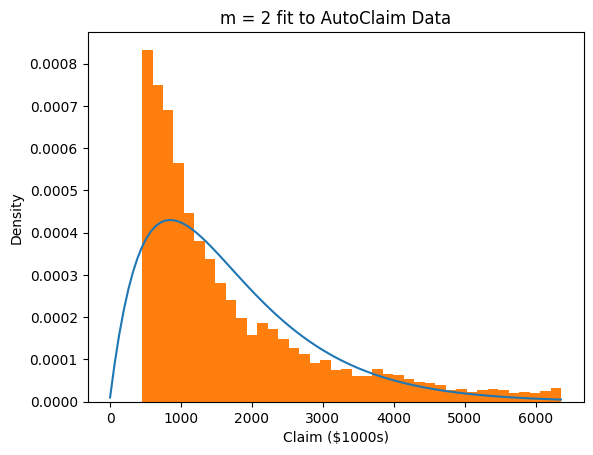

In [7]:
plt.plot(np.linspace(0,max(clmdata),100), [pi@expm(T*x)@t for x in np.linspace(0,max(clmdata),100)])
plt.hist(clmdata,bins=40,density=True)
plt.title("m = 2 fit to AutoClaim Data")
plt.xlabel("Claim ($1000s)")
plt.ylabel("Density")
plt.show()

In [282]:
beta = np.linspace(1,3,5)
surp = np.linspace(0,2000,100)
t = -T@np.ones(p)
pi_ = -(3*(pi@np.linalg.inv(T)))
#pi_@expm(T+np.outer(t,pi_))
np.linalg.inv(T)

array([[-8.51640644e+02, -1.85351168e-39],
       [-8.51616019e+02, -8.58857997e+02]])

In [211]:
def psi(u,beta,T,t,pi):
    pi_ = -(beta*(pi@np.linalg.inv(T)))
    #pi_@expm((T_+np.outer(t_,pi_))*u)@np.ones(2)
    return pi_@expm((T+np.outer(t,pi_))*u)@np.ones(p)

In [213]:
psi(1,3,T,t,pi)

102609.34530644033

In [247]:
-1/(pi@np.linalg.inv(T)@np.ones(p))
beta = 0.0005

0.0005871295934756828

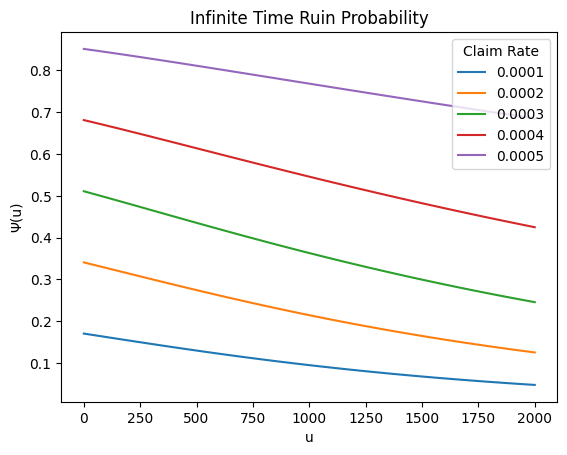

In [284]:
pi2 = 0.5*np.ones(2)
T_ = np.array([[-3,0],[0,-7]])
t_ = -T_@np.ones(2)
psi(0,0.0001,T,t,pi)
beta = [0.0001,0.0002,0.0003,0.0004,0.0005]#np.linspace(0.0001,0.0005,5)
for b in beta:
    plt.plot(surp, [psi(u,b,T,t,pi) for u in surp])
plt.xlabel("u")
plt.ylabel("\u03a8(u)")
plt.legend(beta, title="Claim Rate")
plt.title("Infinite Time Ruin Probability")
plt.show()

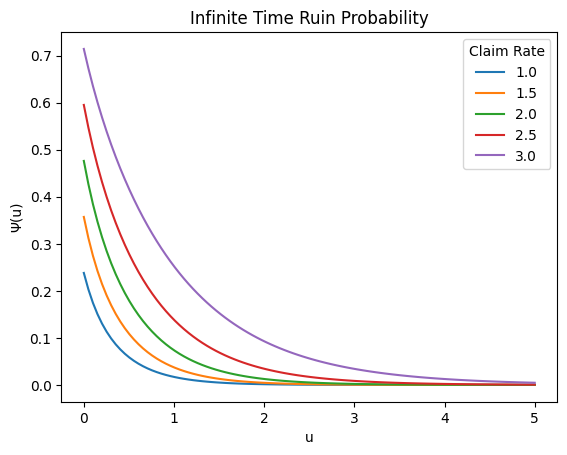

In [273]:
for b in beta:
    plt.plot(surp, [psi(u,b,T_,t_,pi2) for u in surp])
#plt.plot(surp, [24*np.exp(-u)/35 + np.exp(-6*u)/35 for u in surp])
plt.title("Infinite Time Ruin Probability")
plt.xlabel("u")
plt.ylabel("\u03a8(u)")
plt.legend(beta, title="Claim Rate")
plt.show()

In [220]:
pi_ = -3*pi2@np.linalg.inv(T_)
pi_@expm((T_+np.outer(t_,pi_))*2)@np.ones(2)

0.0928015126254588

In [177]:
T_

array([[-3,  0],
       [ 0, -7]])

In [178]:
pi_

array([0.5       , 0.21428571])

In [182]:
t_

array([3., 7.])